# Συστήματα Πολυμέσων

In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt
import wave
from scipy.io.wavfile import write
from scipy.io.wavfile import read
from numpy import linalg as LA
from scipy.fftpack import dct,idct
from heapq import heappush, heappop, heapify
import heapq
from collections import defaultdict

In [2]:
# read h and wav file
hdata=np.load('h.npy',allow_pickle='False')
Tq=np.load('Tq.npy',allow_pickle='False')[0]

# do this in order to function properly
h=hdata.flatten()[0]['h'].flatten()
# open the .wav file
with wave.open('myfile.wav', 'rb') as wav_file:
    # read the .wav file
    fs = wav_file.getframerate()
    wavframes = wav_file.readframes(-1)
    wavin = np.frombuffer(wavframes, dtype=np.int16)

In [3]:
# ready to use functions

def frame_sub_analysis(xbuff: np.ndarray, H: np.ndarray, q: int) -> np.ndarray:
	"""
	"""
	L, M = H.shape
	ind = np.zeros([q, L])
	ind[0, :] = np.arange(L)

	for i in range(1, q):
		ind[i, :] += ind[i - 1, :] + M
	ind = ind.astype(np.int64)
	X = xbuff[ind]
	Y = np.einsum('ik,kj->ij', X, H)
	return Y

def frame_sub_synthesis(ybuff: np.ndarray, G: np.ndarray) -> np.ndarray:
	"""
	"""
	L, M = G.shape
	N = int(np.ceil(L / M))

	Gr = G.reshape(M, M * N, order='F').copy()
	Z = np.zeros([1152])
	for n in range(ybuff.shape[0] - N):
		tmp = ybuff[n:n + N, :].T.flatten()
		yr = np.expand_dims(tmp, axis=-1)
		z = np.dot(Gr, yr)
		Z[n * M:(n + 1) * M] = M * np.flip(z[:, 0])
	return Z.T.flatten()

def make_mp3_analysisfb(h: np.ndarray, M: int) -> np.ndarray:
	"""
	"""
	H = np.zeros([len(h), M], dtype=np.float32)
	for i in range(1, M + 1):
		n = np.arange(h.shape[0], dtype=np.int64)
		freq_i = (2 * i - 1) * np.pi / (2.0 * M)
		phas_i = -(2 * i - 1) * np.pi / 4.0
		tmp = np.cos(freq_i * n + phas_i)
		x = np.multiply(h, tmp)
		H[:, i - 1] = x
	return H

def make_mp3_synthesisfb(h: np.ndarray, M: int) -> np.ndarray:
	"""
	"""
	H = make_mp3_analysisfb(h, M)
	L = len(h)
	G = np.flip(H, axis=0)
	return G

def idonothing(Yc: np.ndarray) -> np.ndarray:
	return Yc

def donothing(Yc: np.ndarray) -> np.ndarray:
	return Yc

In [4]:
# initialize variables
M=32;
N=36;
L=h.shape[0];
# calculate H,G
H=make_mp3_analysisfb(h,M)
G=make_mp3_synthesisfb(h,M)

In [5]:
def plotHi(H,M,fs):
    
    # calculate and plot the transfer functions
    fig , axs = plt.subplots(2,1,figsize=(10,7) )
    for j in range(0,M):
        # fourier transform
        H2 = np.fft.fft(H[:,j])
        # shift in order for the frequencies to be in order
        H2 = np.fft.fftshift(H2)
        # same for the frequencies
        freq = np.fft.fftfreq(len(H[:,j]), d=1/fs)
        freq = np.fft.fftshift(freq)
        # Hz to Bark
        bark = 13*np.arctan(0.00076*freq) + 3.5*np.arctan((freq/7500)**2)
        # calculate in dB
        db = 10*np.log10(np.abs(H2)**2)
        # plot each case
        axs[0].plot(freq,db)
        axs[1].plot(bark,db)

    axs[1].set(xlabel='Frequency (Bark)')
    axs[0].set(xlabel='Frequency (Hz)')
    axs[0].set(ylabel='Magnitude (dB)')
    axs[1].set(ylabel='Magnitude (dB)')

    plt.show()

In [6]:
def coder0(wavin,h,M,N):
    
    # calculate H
    H = make_mp3_analysisfb(h,M)
    
    # samples per frame
    sPF=M*N

    # int number of iterations
    iterations=wavin.shape[0]//sPF

    # initialize the matrix with the frames
    Ytot=np.zeros([iterations*N,M])

    # fill with zeros
    tempwav = np.append(wavin, np.zeros(512))
    #tempwav= wavin
    
    D=Dksparse(M*N-1)
    
    # iterate to change the buffer in each iteration
    for i in range (0,iterations-1):
        
        # (N-1)*M+L samples in the buffer
        # initialize buffer
        xbuff = tempwav[i*sPF:(i+1)*sPF+L-M]
        
        # calculate the i-th frame
        Y=frame_sub_analysis(xbuff,H,N)
        
        # do nothing
        Yc=donothing(Y)

        # save the frame in a matrix
        Ytot[i*N:i*N+N,:]=Yc
        
    return Ytot

In [7]:
def decoder0(Ytot,h,M,N):
    # calculate G
    G=make_mp3_synthesisfb(h,M)
    
    # initialize xhat
    xhatsize= Ytot.shape[0] * Ytot.shape[1] 
    xhat=np.zeros(xhatsize)
    
    # samples per frame
    sPF=M*N

    # int number of iterations
    iterations=xhatsize//sPF
    L= G.shape[0]

    #iterate to change the buffer
    for i in range (0,iterations-1):
        # read from frames matrix
        Yc=Ytot[i*N : i*N+N-1+L//M,:]

        # inverse do nothing
        Yh = idonothing(Yc)

        # fill xhat with N*M samples each iteration
        xhat[i*sPF: (i+1)*sPF]= frame_sub_synthesis(Yh,G)
    return xhat

In [8]:
def codec0(wavin,h,M,N):
    
    Ytot = coder0(wavin,h,M,N)
    xhat = decoder0(Ytot,h,M,N)
    
    return xhat,Ytot

In [9]:
def frameDCT(Y):
    
    # apply DCT to both axis
    c = dct(dct(Y, axis=0, norm='ortho'), axis=1, norm='ortho')
    # flatten into M*N x 1 array
    c = c.flatten()
    return c

In [10]:
def iframeDCT(c):
    # reshape c into 36x32
    Yh = idct(idct(c.reshape(36, 32), axis=0, norm='ortho'), axis=1, norm='ortho')
    return Yh

In [11]:
def DCTpower(c):
    
    # calculate P
    P=10*np.log10(np.abs(c)**2)
    return P

In [12]:
def Dksparse(Kmax): # Kmax = 1151
    
    # function to help with calculation      
    def jInInterval(k,j):
        # 3 different intervals of k
        if ( k > 1 and k < 281):
            # j=2 in this case
            if (j==1):
                return 1

        if ( k >= 281 and k<569):
            # 2<=j<=13
            if ( j >= 1 and j<= 12):
                return 1

        if ( k >= 569 and k < 1152):
            # 2<=j<=27
            if ( j >= 1 and j<= 26):
                return 1

        return 0
    
    D = np.zeros([Kmax,Kmax])
    
    for k in range (Kmax):
        for j in range (Kmax):
            # use helper function
            if ( jInInterval(k,j) ):
                D[k,j]=1
    
    return D

In [13]:
def STinit(c,D):
    
    # get array P
    P=DCTpower(c)
    
    # initialize ST
    ST=np.empty(0)
    
    # iterate for the possible values of k
    for k in range(3,c.shape[0]-27):
        # P[k] needs to be higher than the values next to it
        if( P[k]>P[k-1] and P[k]>P[k+1] ):
            
            # add 1 in order to get the correct number,without +1 it would return [1,12] and [1,26]
            Dk= np.where(D[k,:]==1)[0]+1
            
            # P[k] needs to be 7db higher than all these 'neighbours'
            if np.all( P[k]>P[k-Dk]+7):
                
                if np.all(P[k]>P[k+Dk]+7 ):
                    
                    # add k to array if all '4' (more than 4 for k>282) conditions are fulfilled
                    ST=np.append(ST,k)
    
    return ST

In [14]:
def MaskPower(c,ST):
    
    # get array P
    P=DCTpower(c)
    
    # initialize PM
    PM = np.empty(0)
    
    # iterate ST's values
    for k in ST:
        
        # new sum for each k
        sum=0
        
        #  Sum for j=-1 up to 1
        for j in (-1,0,1):
            
            sum += 10**(0.1*P[int(k)+j])
        
        # add Pm[k] value to PM
        PM=np.append(PM,10*np.log10(sum))
    
    return PM

In [15]:
def Hz2Barks(f):
    # formula , as used in question 3.1.3
    z = 13*np.arctan(0.00076*f) + 3.5*np.arctan((f/7500)**2)
    return z

In [16]:
def STreduction(ST,c,Tq):
    
    # set fs/2
    fs= 44100/2
    
    # get array PM
    PM=MaskPower(c,ST)
    
    # initialize the indexes we want to remove
    toberemoved = np.empty(0)
    # iterate depending on the number of values of ST
    for i in range(ST.shape[0]):
        
        # PM[i] is calculated from ST[i] in MaskPower
        if PM[i] < Tq[int(ST[i])]:
            
            # if condition is true, keep index to remove
            toberemoved = np.append( toberemoved , i)
            
    # remove afterwards in order for the loop to finish uninterrupted
    STr = np.delete( ST, toberemoved.astype(int) )
    PMr = np.delete( PM, toberemoved.astype(int) )
    
    # find the distance in Hz of each of ST's values
    Hzarray = STr*fs/c.shape[0]
    # convert to barks
    z = Hz2Barks(Hzarray)
    
    if len(z)==1:
        return STr , PMr
    
    remove = np.empty(0)
    # for n values do n-1 comparisons
    for i in range(STr.shape[0]-1):
        # check second - first , third - second ....
        if ( z[i+1]- z[i] < 0.5):
            # if PM[i] is smaller, argmin gives 0 so add i , if PM[i+1] argmin gives 1 so add i
            remove =  np.append(remove , np.argmin([PMr[i],PMr[i+1]]) + i )
    # remove again
    STr = np.delete ( STr, remove.astype(int))
    PMr = np.delete ( PMr, remove.astype(int))
    
    return STr , PMr

In [17]:
def SpreadFunc(ST,PM,Kmax):
    # set fs/2
    fs=22050
    # initialize Sf
    Sf = np.zeros((Kmax+1,len(ST)))
    # iterate over both axis
    for i in range(Kmax+1):
        for k in range(len(ST)):
            # convert each axis to Hz and then Hz2Barks
            Dz= Hz2Barks(i*fs/1152) - Hz2Barks(k*fs/1152)
            # the different cases for Dz's value
            if Dz>-3 and Dz<-1:
                Sf[i,k]= 17*Dz-0.4*PM[k]+11
            
            if Dz>=-1 and Dz<0:
                Sf[i,k]= Dz*(0.4*PM[k]+6)
            
            if Dz>=0 and Dz<1:
                Sf[i,k]=-17*Dz
            
            if Dz>=1 and Dz<8:
                Sf[i,k]= Dz * ( 0.15* PM[k]-17) - 0.15*PM[k]
                
    return Sf

In [18]:
def Masking_Thresholds(ST,PM,Kmax):
    # set fs/2
    fs=22050
    # find Spreading function matrix
    Sf=SpreadFunc(ST,PM,Kmax)
    # initialize Ti
    Ti=np.zeros(( Kmax+1,len(ST) ))
    # iterate over both axis
    for i in range(Kmax+1):
        for k in range(len(ST)):
            # convert k to Hz and then to barks
            zk = Hz2Barks(k*fs/1152)
            # calculate Ti[i,k]
            Ti[i,k]=PM[k]-0.275*zk+Sf[i,k]-6.025
    
    return Ti

In [19]:
def Global_Masking_Thresholds(Ti,Tq):
    
    # initialize Tg
    Tg=np.zeros(Ti.shape[0])
    # iterate over its axis
    for i in range ( np.size(Tg)):
        # iterate for k in ST
        sum=0
        for k in range (Ti.shape[1]):
            # add to sum
            sum += 10**(0.1*Ti[i,k])
        # calculate Tg[i]
        Tg[i]=10 * np.log10( 10**(0.1*Tq[i]) + sum  )
    
    return Tg

In [20]:
def psycho(c,D):
    # load since its not given as input
    Tq=np.load('Tq.npy',allow_pickle='False')[0]
    # call functions back to back
    ST=STinit(c,D)
    PM=MaskPower(c,ST)
    STr,PMr = STreduction(ST,c,Tq)
    Ti=Masking_Thresholds(STr,PMr,c.shape[0]-1)
    Tg=Global_Masking_Thresholds(Ti,Tq)
    
    return Tg

In [21]:
def critical_bands(K): # K=1152
    # set fs/2
    fs=22050
    # Hz array
    f= np.arange(K)*fs/K
    # first 2 elements belong to band 1
    cb=np.ones(K)
    #  we will use numpy search sorted function
    bands=np.array([0,100,200,300,400,510,630,770,920,1080,1270,1480,1720,2000,2320,2700,3150,
                   3700,4400,5300,6400,7700,9500,12000,15500],dtype=int)
    # dont include first 2 elements
    for k0 in range(2,K):
        # value of cb[k0] depends on f[k0-1]
        cb[k0]= np.searchsorted( bands, f[k0-1] )
    # turn to int
    cb=cb.astype(int)
    
    return cb

In [22]:
def DCT_band_scale(c):
    # get critical bands array
    cb= critical_bands(c.shape[0])
    # initialize arrays
    cs = np.zeros(c.shape[0])
    sc= np.zeros(25)
    
    #iterate over sc's axis
    for i in range (1,26):
        # find the elements of each band
        band = np.where(cb==i)[0]
        # i=1 means first band , which is stored in sc[0] etc.
        sc[i-1]= np.max (  np.abs(c[band])**(3/4) )
    
    # iterate over cs's axis
    for i in range (cs.shape[0]):
                                        #again cb gives 1-25 , we want 0-24
        cs[i]=  np.sign(c[i]) * np.abs(c[i])**(3/4) / sc[cb[i]-1]
        
    
    return cs,sc

In [23]:
def quantizer(x,b):
    
    # calculate step
    wb= 2 / (2**b)
    
    # initialize matrix
    symb_index=np.zeros(x.shape[0])
    
    # if b=1 we quantize everything to 0
    if b==1:
        return symb_index
    
    # find number of zones before cutting off the middle one
    zones = 2**b
    
    # initialize matrix d
    d = np.zeros( zones +1 )
    
    # fill d -> [-1 , -1+i wb , -1+2i wb , ... , +1]
    for i in range ( zones +1 ):
        d[i] = -1 + i*wb
        
    # remove the 0 in the middle
    d= np.delete ( d , int(len(d)/2))
    
    
    # without this small change, -1 will be quantized wrong , +1 is correct though
    d[0]-=0.000001
    
    # remove offset from following calculation because we want 0 to be index 0 and not -1 to be index 0
    offset= np.searchsorted(d, 0. )
    
    # iterate to fill symb_index
    for i in range( symb_index.shape[0]):
        symb_index[i] = np.searchsorted( d, x[i] ) - offset
    
    return symb_index

In [24]:
def dequantizer(symb_index,b):
    # if b=1 we dequantize everyting to 0
    if b==1:
        xh = np.zeros(symb_index.shape[0])
        return xh
    
    #calculate variables like previously
    wb= 2 / (2**b)
    # number of zones
    zones = 2**b
    # array to use numpy search sorted
    d = np.zeros( zones +1 )
    # fill d
    for i in range ( zones +1 ):
        d[i] = -1 + i*wb
    # remove the zero in the middle
    d= np.delete ( d , int(len(d)/2))
    # calculate offset
    offset= np.searchsorted(d, 0. )
    # initialize xhat
    xh=np.zeros ( symb_index.shape[0])
    # iterate
    for i in range(xh.shape[0]):
        # index of d that symbol corresponds to
        kati = (symb_index[i] - offset).astype(int)
        # uniform
        xh[i] = d[kati]/2 + d[kati-1]/2
    
    return xh

In [25]:
def all_bands_quantizer(c,Tg):
    
    # we will need this later , indexes where Tg is not nan
    not_nan= np.logical_not(np.isnan(Tg))
    
    # calculate needed values
    cs,sc=DCT_band_scale(c)
    cb= critical_bands(c.shape[0])
    
    # initialize b=1
    B=1
    
    # since we dont have the values we need to compare right now , we will find a way to break inside
    loop_condition = True
    while loop_condition:
        
        # quantize cs
        symb_index = quantizer(cs,B)
        # dequantize 
        csdq = dequantizer(symb_index,B)
        # calculate c hat
        chat= np.sign(csdq) * ( np.abs(csdq)*sc[cb-1] )**(4/3)
        # calculate absolute error
        eb= np.abs(c-chat)
        # calculate Pb
        Pb= 10* np.log10( eb**2)

        
        # exit condition , is true if for every value of Tg that is not nan Pb is lower or equal
        if  np.all(   Pb[not_nan] <= Tg[not_nan] ):
            loop_condition = False 
        
        else:
            B+=1
        
    SF=sc    
    
    return symb_index,SF,B

In [26]:
def all_bands_dequantizer(symb_index,B,SF):
    
    # calculate critical bands
    cb=critical_bands(symb_index.shape[0])
    
    # find scaled xhat
    xh=dequantizer(symb_index , B)
    
    # descale xhat 
    xh= np.sign(xh)*(np.abs(xh) * SF[cb-1])**(4/3)
    
    return xh

In [27]:
def RLE(symb_index,K): # K = 1152
    
    # calculate run_symbol's dimensions , we will calculate the case where the first element(s) is zero later
    R = len(np.where(symb_index!=0)[0])
    # boundary case
    if R== symb_index.shape[0] :
        # reshape into column
        symb_index = np.reshape(symb_index, (symb_index.shape[0],1)  )
        # create column of zeros
        second_column=np.zeros((symb_index.shape[0],1))
        # stack symb_index and column of zeros
        run_symbols = np.column_stack((symb_index,second_column))
        
        return run_symbols

    # initialize run symbols array
    run_symbols = np.zeros ((R,2), dtype=int)
    
    # initialize variables
    # current symbol
    current_symbol = None
    
    # number of zeros corresponding to current symbol
    zero_count = 0
    
    # R's first axis index
    run_index = 0
    
    # handle the leading zeros
    # if the sequence start with one zero , we encode 0 0 , if it start with 2 zeros we encode 0 1 etc
    leading_zeros = 0
    while leading_zeros < K and symb_index[leading_zeros] == 0:
        leading_zeros += 1  
    
    # iterate over symb index and add the RLE pairs to the array
    # start with the first non zero element
    i = leading_zeros
    
    ##### this loop is powered by chatgpt
    while i < K:
        symbol = symb_index[i]
        if symbol != 0:
            if current_symbol is not None:
                run_symbols[run_index, :] = [current_symbol, zero_count]
                run_index += 1
            current_symbol = symbol
            zero_count = 0
        else:
            zero_count += 1
        i += 1

    # handle the last run
    if current_symbol is not None:
        run_symbols[run_index, :] = [current_symbol, zero_count]
        
    #####
    
    # calculate the array with R rows and now add the leading zeroes to first row.
    # so now its R+1 x 2 with the definition I gave to R
    if leading_zeros > 0:
        # remove 1 for the reason i mentioned earlier
        run_symbols = np.insert(run_symbols, 0, [0, leading_zeros-1], axis=0)
    
    return run_symbols

In [28]:
def iRLE(run_symbols, K):
    
    # this function doesnt need extra work for leading zeroes √ 
    
    # initialize symbols index
    symb_index = np.zeros(K, dtype=int)
    
    # initialize variable
    index = 0

    # iterate over the run symbols and add the decoded sequence to symbols index
    for i in range(run_symbols.shape[0]):
        
        # get pair of values
        symbol, count = run_symbols[i].astype(int)
        
        # if theres no following zero just write the symbol
        if count == 0:
            symb_index[index] = symbol
        
        # if there are following zeroes write them too after the symbol
        else:
            symb_index[index] = symbol
            symb_index[index+1:index+count+1] = [0]*count
            
        # move 1 index + count
        index += count + 1

    return symb_index # K = 1152

In [29]:
# helper functions
class Node:
    # define a Node class to represent nodes in the Huffman tree
    def __init__(self, symbol=None, probability=0):
        self.symbol = symbol
        self.probability = probability
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.probability < other.probability
    
def generate_codes(node):
    # initialize the stack with the root node and an empty code
    stack = [(node, "")]
    codes = {}
    # process nodes until the stack is empty
    while stack:
        node, code = stack.pop()
        # leaf node: add the code to the dictionary
        if node.left is None and node.right is None:
            codes[node.symbol] = code
        # non-leaf node: add the left and right children to the stack
        else:
            stack.append((node.left, code + "0"))
            stack.append((node.right, code + "1"))
    return codes
        
def reverse_codes(codes):
    # inverse dictionary
    reverse = {}
    for symbol, code in codes.items():
        reverse[code] = symbol
    return reverse


# construct the Huffman tree from the given symbol-probability pairs
def construct_huffman_tree(pairs):
    # initialize M with the pairs from the input array
    M = [Node(symbol, probability) for symbol, probability in pairs]

    # use a heap to keep track of the nodes with the lowest probabilities
    heapq.heapify(M)

    # repeatedly combine the nodes with the lowest probabilities until there's only one node left
    while len(M) > 1:
        # remove the two nodes with the lowest probabilities
        left = heapq.heappop(M)
        right = heapq.heappop(M)

        # create a new node with probability equal to the sum of the probabilities of the two deleted nodes
        new_node = Node(probability=left.probability + right.probability)

        # connect the new node to the deleted nodes
        new_node.left = left
        new_node.right = right

        # add the new node to M
        heapq.heappush(M, new_node)

    # return the root of the Huffman tree
    return M[0]

In [30]:
def huff(run_symbols):
    
    # get symbols index matrix to include the zeroes
    symb_index = iRLE(run_symbols,1152)
    
    # calculate unique values
    uniques = np.unique(symb_index)
    
    # initialize column with frequencies
    freq= np.zeros((uniques.shape[0],1))
    
    # divide by number of symbols
    df = symb_index.shape[0]
    
    for i in range (uniques.shape[0]):
        # find how many times each symbol is in the original sequence and divide by df
        freq[i] = len(np.where( symb_index == uniques[i])[0]) / df

    # column stack uniques column and frequencies column
    uniques=np.reshape(uniques,(uniques.shape[0],1))
    pair = np.column_stack((uniques,freq))
    
    # Construct the Huffman tree from the frequency table
    root = construct_huffman_tree(pair)
    # loop up table dictionary
    codes = generate_codes(root)
    
    
    # initialize frame stream , its a 1152x1 matrix with string objects
    frame_stream = np.zeros(symb_index.shape[0],dtype='object')
    
    for i in range (frame_stream.shape[0]):
        # encode the value of symbols index and assign it to frame stream
        frame_stream[i] =  codes[symb_index[i]]
    
    # rename
    frame_symbol_prob = pair
    
    return frame_stream , frame_symbol_prob

In [31]:
def ihuff(frame_stream, frame_symbol_prob):
    
    # Construct the Huffman tree from the frequency table
    root = construct_huffman_tree( frame_symbol_prob )
    # loop up table dictionary
    codes = generate_codes(root)
    
    # reverse dictionary
    icodes = reverse_codes(codes)
    
    # reverse 0s and 1s into symbols
    symbols = np.zeros(frame_stream.shape[0])
    for i in range ( symbols.shape[0] ):
        symbols[i] = icodes[frame_stream[i]]
    
    # create run lengths from symbols
    run_symbols = RLE(symbols,1152) 
    
    return run_symbols

In [32]:
def MP3coder0(wavin,h,M,N):
    
    # calculate H
    H = make_mp3_analysisfb(h,M)
    
    # samples per frame
    sPF=M*N

    # int number of iterations
    iterations=wavin.shape[0]//sPF

    # initialize the matrix with the frames
    Ytot=np.zeros([iterations*N,M])

    # fill with zeros
    tempwav = np.append(wavin, np.zeros(512))
    #tempwav= wavin
    
    D=Dksparse(M*N-1)
    
    # iterate to change the buffer in each iteration
    
    huffarray = np.zeros((1152,iterations),dtype=object)
    for i in range (0,iterations-1):
        
        # (N-1)*M+L samples in the buffer
        # initialize buffer
        xbuff = tempwav[i*sPF:(i+1)*sPF+L-M]
        
        # calculate the i-th frame
        Y=frame_sub_analysis(xbuff,H,N)
        
        # do nothing
        Yc=donothing(Y)
        
        c=frameDCT(Yc)
        
        Tg=psycho(c,D)
        
        symb_index,SF,B = all_bands_quantizer(c,Tg)
        
        run_symbols = RLE(symb_index,1152)
        
        f1,f2 = huff(run_symbols)
        
        huffarray[:,i]=f1
        
        run_lengths = ihuff(f1,f2)
        
        symb_index = iRLE(run_lengths,1152)
        
        chat = all_bands_dequantizer(symb_index,B,SF)
        
        Yc=iframeDCT(chat)

        # save the frame in a matrix
        Ytot[i*N:i*N+N,:]=Yc
        
    return Ytot,huffarray

In [33]:
def MP3decoder0(Ytot,h,M,N):
    # calculate G
    G=make_mp3_synthesisfb(h,M)
    
    # initialize xhat
    xhatsize= Ytot.shape[0] * Ytot.shape[1] 
    xhat=np.zeros(xhatsize)
    
    # samples per frame
    sPF=M*N

    # int number of iterations
    iterations=xhatsize//sPF
    L= G.shape[0]

    #iterate to change the buffer
    for i in range (0,iterations-1):
        # read from frames matrix
        Yc=Ytot[i*N : i*N+N-1+L//M,:]

        # inverse do nothing
        Yh = idonothing(Yc)

        # fill xhat with N*M samples each iteration
        xhat[i*sPF: (i+1)*sPF]= frame_sub_synthesis(Yh,G)
    return xhat

In [34]:
def MP3codec0(wavin,h,M,N):
    
    Ytot , huffarray = MP3coder0(wavin,h,M,N)
    xhat = MP3decoder0(Ytot,h,M,N)
    
    return xhat,Ytot,huffarray

SNR is: 15.60086667356363


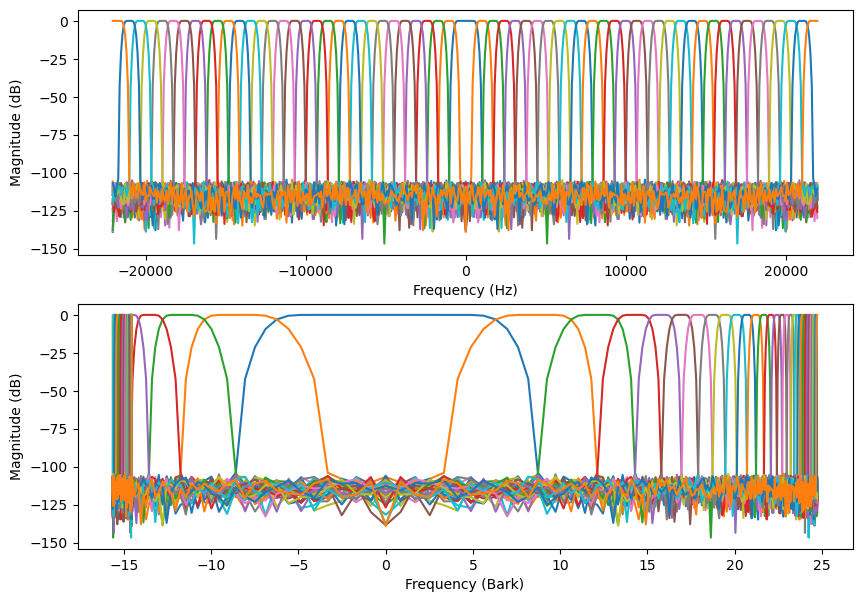

In [35]:
# call functions
[xhat,Ytot]=codec0(wavin,h,M,N)
temp=xhat[514944-480:514944]
xhat[480:514944]= xhat[:514944-480]
xhat[0:480]=temp
px= np.mean(wavin.astype(np.float32)**2)
pe= np.mean( (wavin-xhat)**2 )
SNR= 10*np.log10(px/pe)
xhat =xhat / np.max(xhat) * 0.6
write("xhat.wav", fs, xhat)
print('SNR is:' ,SNR)
plotHi(H,M,fs)

In [ ]:
# call functions with huffman implementation
[xhat2,Ytot2,huffarray]=MP3codec0(wavin,h,M,N)
temp2=xhat2[514944-480:514944]
xhat2[480:514944]= xhat2[:514944-480]
xhat2[0:480]=temp2
pe2= np.mean( (wavin-xhat2)**2 )
SNR2= 10*np.log10(px/pe2)
xhat2 =xhat2 / np.max(xhat2) * 0.6
write("xhat2.wav", fs, xhat2)
print('SNR for the decoded sequence after using all of the functions is:' ,SNR2)
sum = 0
for i in range(447):
    for j in range (1152):
        if huffarray[j,i]==0:
            sum+=1
        else:
            sum += len(huffarray[j,i])
print('Size in bytes of the Huffman sequence is :' ,sum/8 )